# Análisis, limpieza y transformación de los datos fiscales de las empresas
El siguiente cuaderno trata de todas las actividades relacionadas con el preprocesamiento de los datos fiscales de las empresas de Colombia.

El objetivo de este cuaderno es comprender, limpiar, y transformar los datos fiscales de las empresas para que tengan la máxima calidad posible de cara a los procesos y algoritmos de aprendizaje automático.

Este cuaderno procede al preprocesamiento de datos básicos y a la extracción de datos externa. El orden elegido sigue un motivo principal, y es que para preprocesar los datos fiscales pueden ser necesarios ciertos datos básicos de empresa, pero no al revés.

El dataset de los datos fiscales es una extracción realizada por el director del proyecto, Santiago Rojo, que está dividida en tres fuentes de datos distintas. Cada fuente corresponde a un ejercicio fiscal diferente para las empresas seleccionadas durante el período 2017-2019.

Las columnas del dataset representan los datos fiscales en el cierre de cada ejercicio. Las variables presentan una alta relación entre sí, ya que algunas variables son agregaciones (principalmente sumas) de otras.

Cabe mencionar que, existe la posibilidad que una variable agregada no contenga todas sus partes en el mismo dataset. Por ejemplo, el valor del patrimonio no equivale siempre al valor de sus subconceptos (capital social, superávit...). Esto se debe a que la extracción ha omitido algunos conceptos (partidas) que las empresas declaran. Por lo tanto, el dataset de origen se trata de una selección de aquellas partidas fiscales más importantes en los cierres de cada ejercicio. Obviamente incluye los datos necesarios para etiquetar las empresas, actividad que se realiza en el siguiente cuaderno. 

El conjunto de datos se encuentra repartido en tres ficheros. Cada uno representa un ejercicio distinto:

* **data/Balance2017.xls**: Para los datos del ejercicio del 2017.
* **data/Balance2018.xls**: Para los datos del ejercicio del 2018.
* **data/Balance2019.xls**: Para los datos del ejercicio del 2019.

Las variables del dataset y su descomposición jerárquica se describen a continuación. Si no se indica lo contrario, cada variable de un nivel concreto es igual a la suma de todas sus variables del nivel inmediatamente inferior.

* ID: Identificador de empresa.
* AC: Activo de la empresa = ACC + ACL.
    * ACC: Total activo corriente = ACC13 + ACC114 + ACC118 + ACC11H + ACC211 + Otros conceptos no presentes.
        * ACC113: Cuentas por cobrar - deudores.
        * ACC114: Inventarios.
        * ACC118: Otros activos.
        * ACC11H: Activos por impuestos corrientes.
        * ACC211: Efectivo y equivalentes.
    * ACL: Activos no corrientes = ACL115 + ACL118 + ACL11M + ACL11Q + ACL11R + Otros conceptos no presentes.
        * ACL115: Propiedades planta y equipo.
        * ACL118: Otros activos.
        * ACL11M: Propiedad de inversión.
        * ACL11Q: Activos intangibles distintos de la plusvalía.
        * ACL11R: Activos por impuestos diferidos
* P: Total pasivo + patrimonio = PS + PT. También equivale al activo P = AC
* PS: Pasivos = PSC + PSL.
    * PSC: Pasivos corrientes = PSC223 + PSC224 + PSC225 + PSC228 + Otros conceptos no presentes.
        * PSC223: Cuentas por pagar corrientes.
        * PSC224: Pasivos por impuestos corrientes.
        * PSC225: Provisiones corrientes por beneficios a.
        * PSC228: Otros pasivos corrientes.
    * PSL: Pasivos no corrientes = PSL12J + PSL228 + Otros conceptos no presentes.
        * PSL12J: Pasivo por impuestos diferidos.
        * PSL228: Otros pasivos no corrientes.
* PT: Patrimonio = PTT131 + PTT131 + PTT133 + PTT136 + PTT237 + Otros conceptos no presentes.
    * PTT131: Capital social.
    * PTT132: Superávit de capital.
    * PTT133: Reservas.
    * PTT136: Resultado ejercicio. (es igual a la variable R)
    * PTT237: Ganancias acumuladas.
* R: Utilidad neta (Ingresos menos deudas y obligaciones) = RA - RIII
    * RA: Resultado antes de los impuestos = RAE + RAX o bien RAI - RAG
        * RAE: Resultados operacionales = RAIE - RAGE.
        * RAG: Total gastos = RAGE + RAGX.
        * RAI: Total ingresos = RAIE + RAIX.
        * RAX: Resultado no operacional = RAIX - RAGX.
    * RIII: Impuesto de renta y complementarios.

* RAG (Descomposición): Total gastos = RAGE + RAGX
    * RAGE: Costos y gastos operacionales.
        * RAGE51: Gastos de administración.
        * RAGE52: Gastos de ventas.
        * RAGE55: Otros gastos operativos.
        * RAGE60: Costo de ventas.
    * RAGX: Gastos no operacionales.
        * RAGXFI: Gastos financieros.
* RAI (Descomposición): Total ingresos = RAIE + RAIX
    * RAIE: Ingresos operacionales.
    * RAIX: Ingresos no operacionales.
        * RAIXFI: Ingresos financieros.
* RAX (Descomposición): Resultado no operacional = RAIX - RAGX.
    * RAXFI: Resultado financiero
    
Esta jerarquía ha sido deducida manualmente a través de una inspección manual y con la ayuda de las fórmulas en un libro de Excel. La descripción de las columnas la proporciona el director del proyecto y se puede encontrar en **data/Partidas.xlsx**.

Todos los valores representan pesos colombianos, y la unidad se fija en mil pesos.

En primer lugar se realiza un análisis preliminar de los datos.

In [1]:
# Importes necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import matplotlib as mpl


Bad key "text.kerning_factor" on line 4 in
c:\users\joan\appdata\local\programs\python\python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Obtener los datos del fichero fuente
ejercicio2017 = pd.read_excel('data/Balance2017.xls')

# Mostrar las columnas, su tipo de datos, y el número de celdas perdidas
ejercicio2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13357 entries, 0 to 13356
Data columns (total 48 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      13357 non-null  int64  
 1   AC      13357 non-null  float64
 2   ACC     13357 non-null  float64
 3   ACC11H  7508 non-null   float64
 4   ACC113  13107 non-null  float64
 5   ACC114  9237 non-null   float64
 6   ACC118  6802 non-null   float64
 7   ACC211  13276 non-null  float64
 8   ACL     13354 non-null  float64
 9   ACL11M  3149 non-null   float64
 10  ACL11Q  4333 non-null   float64
 11  ACL11R  5810 non-null   float64
 12  ACL115  12612 non-null  float64
 13  ACL118  5234 non-null   float64
 14  P       13357 non-null  float64
 15  PS      13357 non-null  float64
 16  PSC     13356 non-null  float64
 17  PSC223  13067 non-null  float64
 18  PSC224  11206 non-null  float64
 19  PSC225  8259 non-null   float64
 20  PSC228  10267 non-null  float64
 21  PSL     13356 non-null  float64
 22

A través de la inspección manual de los datos, se observa que los valores perdidos en realidad representan el **valor numérico 0**. Esto es fácilmente comprobable a través de los valores agregados que tienen partes perdidas en sus conceptos individuales. Si se substituyen los valores perdidos por 0, las sumas siguen resultando correcto en la gran mayoría de filas.

Por lo tanto, a priori, todos los valores perdidos de las fuentes de datos deben ser tratados como ceros. Se asume que son partidas que la empresa no ha declarado.

Antes de empezar el análisis preliminar, se juntan todas las fuentes de datos en un único dataset que contenga el año del ejercicio como una variable añadida.

In [3]:
# Obtener los datos del fichero fuente
ejercicio2018 = pd.read_excel('data/Balance2018.xls')
ejercicio2019 = pd.read_excel('data/Balance2019.xls')

# Asignar la columna año a cada dataset
ejercicio2017['Anyo'] = 2017
ejercicio2018['Anyo'] = 2018
ejercicio2019['Anyo'] = 2019

# Concatenar los ejercicios
ejercicios = pd.concat([ejercicio2017, ejercicio2018, ejercicio2019])

In [4]:
# Mostrar la longitud total del dataset cuando se tienen todos los ejercicios
len(ejercicios)

40071

In [5]:
# Llenar los valores perdidos con 0
ejercicios = ejercicios.fillna(0)

Para tener una visión global de las variables del dataset, se analizan las distribuciones de las principales agregaciones presentes.

Es necesario utilizar una escala logarítmica para el eje vertical del histograma, ya que todas las distribuciones económicas siempre tienden a presentar unos valores extremos muy pronunciados, que dificultan en gran medida su interpretación.

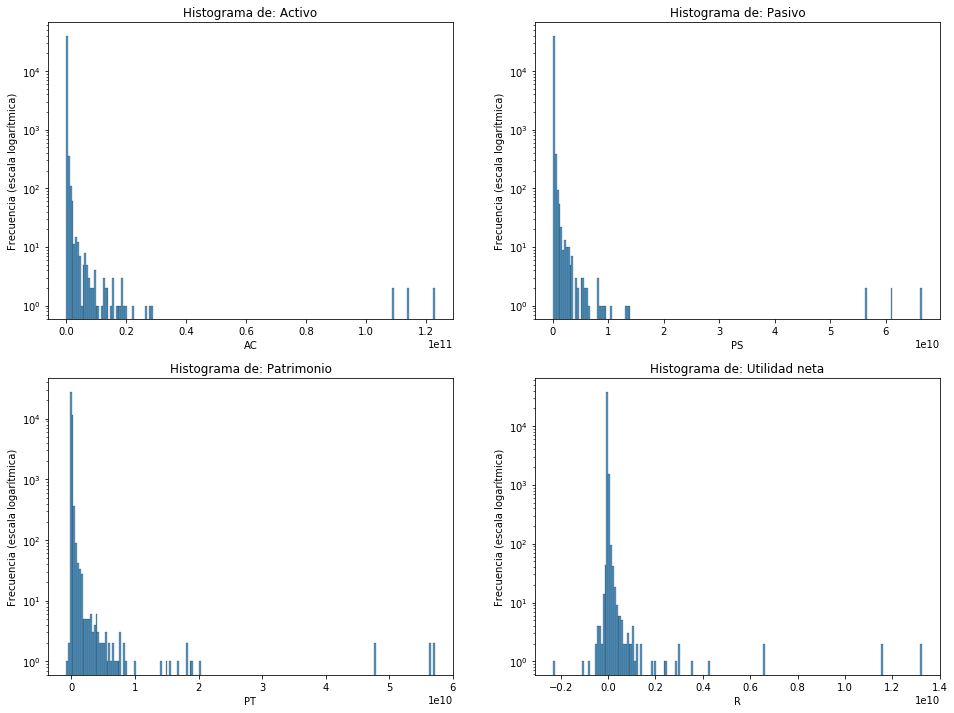

In [6]:
# Construir las visualizaciones con los histogramas de las principales variables fiscales
fig, axes = plt.subplots(2,2, figsize=(16,12))

def plot_hist_fiscal(df, variable, nombre, i, j, axes):
    sns.histplot(data=df,x=variable, bins=200, log_scale=(False,True), ax=axes[i][j])
    axes[i][j].set_title("Histograma de: {0}".format(nombre))
    axes[i][j].set_ylabel("Frecuencia (escala logarítmica)")

plot_hist_fiscal(ejercicios, "AC", "Activo", 0, 0, axes)
plot_hist_fiscal(ejercicios, "PS", "Pasivo", 0, 1, axes)
plot_hist_fiscal(ejercicios, "PT", "Patrimonio", 1, 0, axes)
plot_hist_fiscal(ejercicios, "R",  "Utilidad neta", 1, 1, axes)
    
plt.show()

Los histogramas revelan que:

* Existen diferencias abismales entre las pequeñas y las grandes empresas respecto a las partidas. Puede haber diferencias de millones entre una empresa y otra, y eso teniendo en cuenta que las unidades se expresan en miles de pesos.
* La utilidad neta puede ser negativa. Esto significa que la empresa presenta pérdidas en el ejercicio concreto.
* El activo y el pasivo siempre son positivos.
* El patrimonio puede ser negativo y significa posibles ajustes corrientes a realizar.

Es esperable que el resto de variables del dataset tengan el mismo patrón de desigualdad.

Si se consideran como outliers aquellos valores a más de 3 rangos intercuartílico de los quintiles 1 y 3, se pueden obtener los histogramas sin escalar.

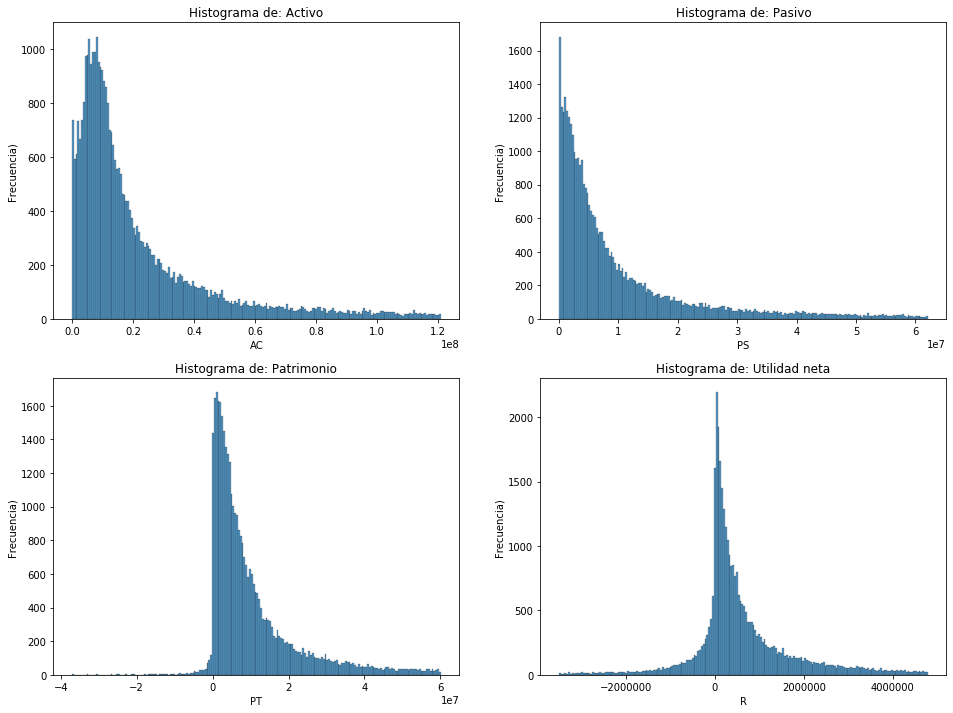

In [7]:
def plot_hist_fiscal_normal(df, variable, nombre, i, j, axes):
    sns.histplot(data=df,x=variable, bins=200, ax=axes[i][j])
    axes[i][j].set_title("Histograma de: {0}".format(nombre))
    axes[i][j].set_ylabel("Frecuencia)")
    
# Eliminar los valores atípicos
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    return df[(df[column] >= (Q1 - 3 * IQR)) & (df[column] <= (Q3 + 3 * IQR))]

# Construir las visualizaciones con los histogramas de las principales variables fiscales
fig, axes = plt.subplots(2,2, figsize=(16,12))

plot_hist_fiscal_normal(remove_outliers(ejercicios, "AC"), "AC", "Activo", 0, 0, axes)
plot_hist_fiscal_normal(remove_outliers(ejercicios, "PS"), "PS", "Pasivo", 0, 1, axes)
plot_hist_fiscal_normal(remove_outliers(ejercicios, "PT"), "PT", "Patrimonio", 1, 0, axes)
plot_hist_fiscal_normal(remove_outliers(ejercicios, "R"), "R", "Utilidad neta", 1, 1, axes)

Cuando no se consideran los outliers, se pueden observar las distribuciones mucho mejor. El activo se asemeja a una distribución log-normal, el pasivo a una exponencial, y el patrimonio y la utilidad neta presentan una distribución característica. 

### Variables redundantes
Una gran parte de las variables del dataset son resultado de operaciones sobre otras variables del dataset, por lo que es esperable que, en conjunto, las variables presenten una alta correlación.

Por ejemplo, la utilidad neta es el resultado de la diferencia entre el resultado antes de los impuestos y los impuestos. Así como el activo equivale al pasivo más el patrimonio.

Las variables que presenten una alta correlación deben ser identificadas para tomar una decisión sobre su permanencia. La decisión más sencilla consiste en eliminar todas las variables que presenten correlación, dejando únicamente una. Las correlaciones no aportan demasiada información y pueden perturbar los modelos de aprendizaje automático.

En primer lugar se comprueban aquellas variables granulares, que son resultado de sus partes, para detectar posibles correlaciones. Estas variables son:

* ACC (Activo corriente).
* ACL (Activo no corriente).
* PSC (Pasivo corriente).
* PSL (Pasivo no corriente).
* PTT131, PTT132, PTT237: Todas las que forman el patrimonio salvo el resultado del ejercicio.
* RAGE: Gastos operacionales.
* RAGX: Gastos no operacionales.
* RAGXFI: Gastos financieros.
* RAIE: Ingresos operacionales.
* RAIX: Ingresos no operacionales.
* RAXFI: Resultado financiero.
* RIII: Impuestos.

Se realiza la prueba de Spearman con todos los pares de variables del dataset. Esta prueba evalúa si las variables presentan una correlación monótona. Cuanto mayor sea el coeficiente de Spearman (hasta 1 o -1), mayor es su relación de correlación monótona. Esto significa que las dos variables crecen o decrecen a la vez.

La prueba de Spearman no requiere de distribuciones normales por lo que resulta más adecuada que la de Pearson. Se trata de una prueba de rango.

Antes de realizar la prueba se deben filtrar los valores atípicos posibles para evitar un bias en el estadístico.

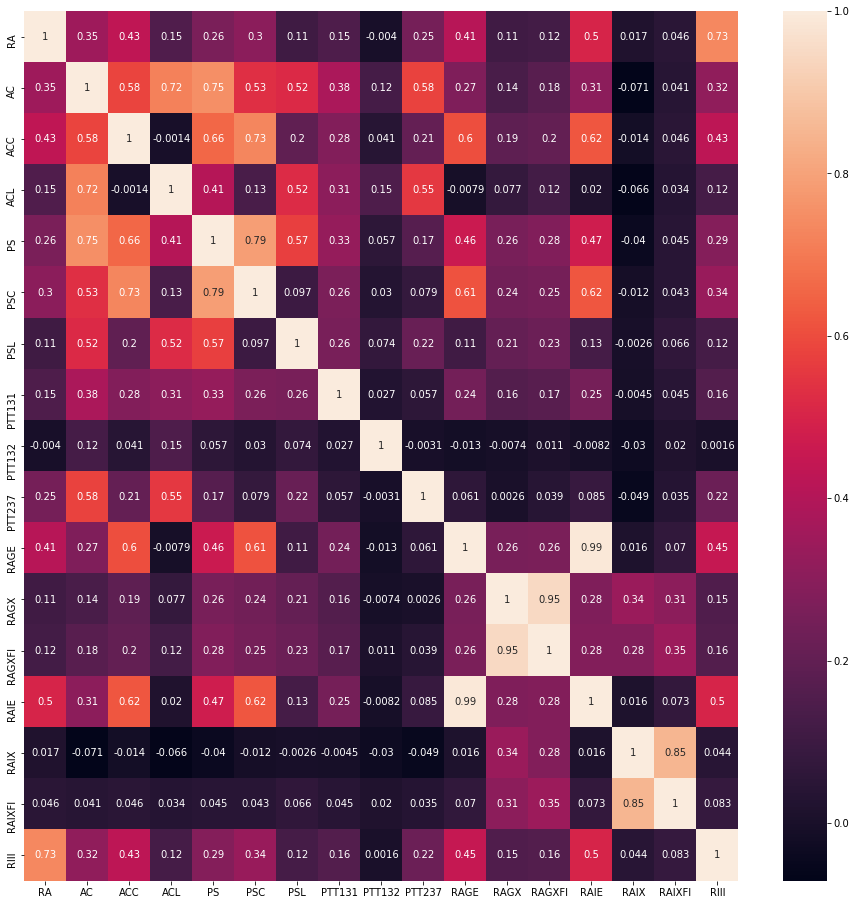

In [8]:
def removeAllOutliers(df, columns):
    for column in columns:
        df = remove_outliers(df, column)
    return df

def corr_plot(df, variables,method='spearman'):
    df_corr = df[variables]
    # Matriz de correlaciones
    mat = df_corr.corr(method)
    fig = plt.figure(figsize=(16,16))
    sns.heatmap(mat, annot=True)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

variablesAtomicas = ['RA','AC','ACC','ACL','PS','PSC','PSL','PTT131', 'PTT132', 'PTT237','RAGE','RAGX','RAGXFI','RAIE','RAIX','RAIXFI','RIII']
corr_plot(removeAllOutliers(ejercicios,variablesAtomicas), variablesAtomicas)

La matriz de correlaciones monótonas revela que:

1. El activo corriente crece y decrece con el pasivo corriente. También lo hace el pasivo corriente con el no corriente pero en menor medida.
2. El activo y el pasivo corrientes también crece con los costos y gastos operacionales.
3. A mayor resultado del ejercicio (RA) mayores impuestos (RIII), esto es esperable, ya que casi siempre los impuestos son en función del resultado.
4. Los ingresos operaciones y los gastos operacionales también crecen en acorde.
5. Los ingresos no operacionales y su parte financiera crecen en la misma medida. Este comportamiento también se observa en los gastos no operacionales y su parte financiera.

Las otras variables no parecen tener gran correlación.

En segundo lugar, se comprueban cuáles variables del activo corriente y el pasivo corriente presentan correlación.

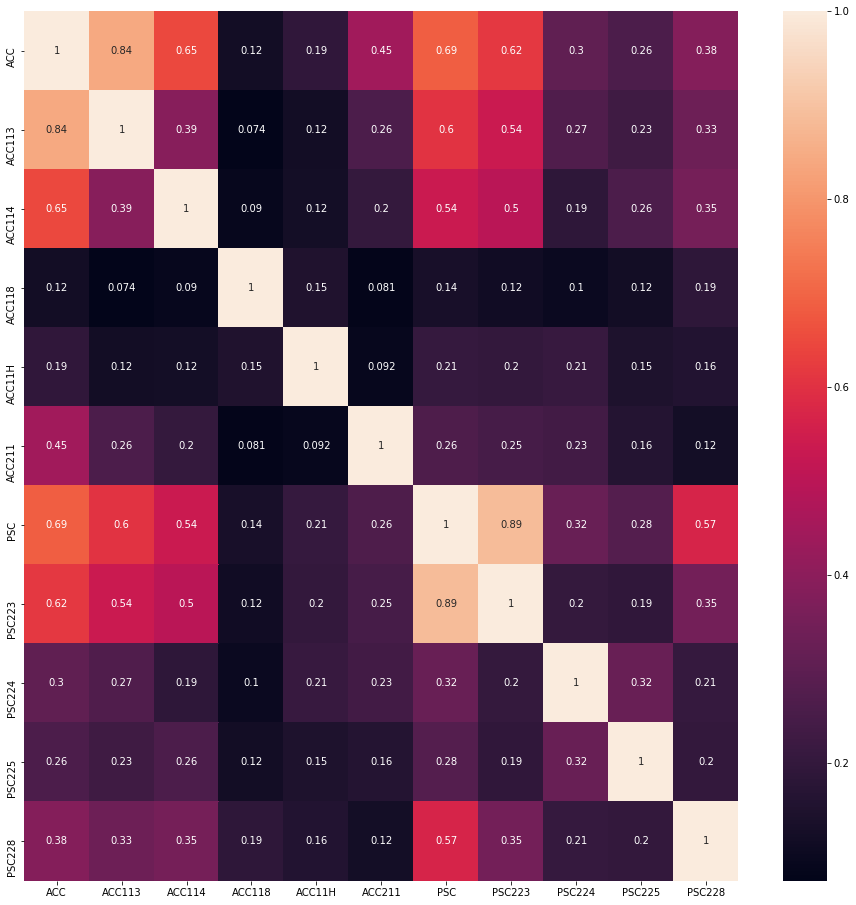

In [9]:
variablesCorrientes = ['ACC','ACC113','ACC114','ACC118','ACC11H','ACC211', 'PSC','PSC223','PSC224','PSC225','PSC228']
corr_plot(removeAllOutliers(ejercicios,variablesCorrientes), variablesCorrientes)

Se observa como el activo corriente y las cuentas por cobrar presentan una alta correlación, posiblemente las cuentas por cobrar representen un alto porcentaje del activo corriente en muchas empresas, por lo que crecen y decrecen en consecuencia.

Este comportamiento también sucede con el pasivo corriente y las cuentas por pagar. Por lo tanto, todas las 4 variables se encuentran más o menos relacionadas, ya que el activo corriente y el pasivo corriente también varían en consecuencia.

No se observa ninguna otra correlación significativa entre variables. 

Ahora se observan las correlaciones en las variables de activos y pasivos no corrientes, o también denominados a largo.

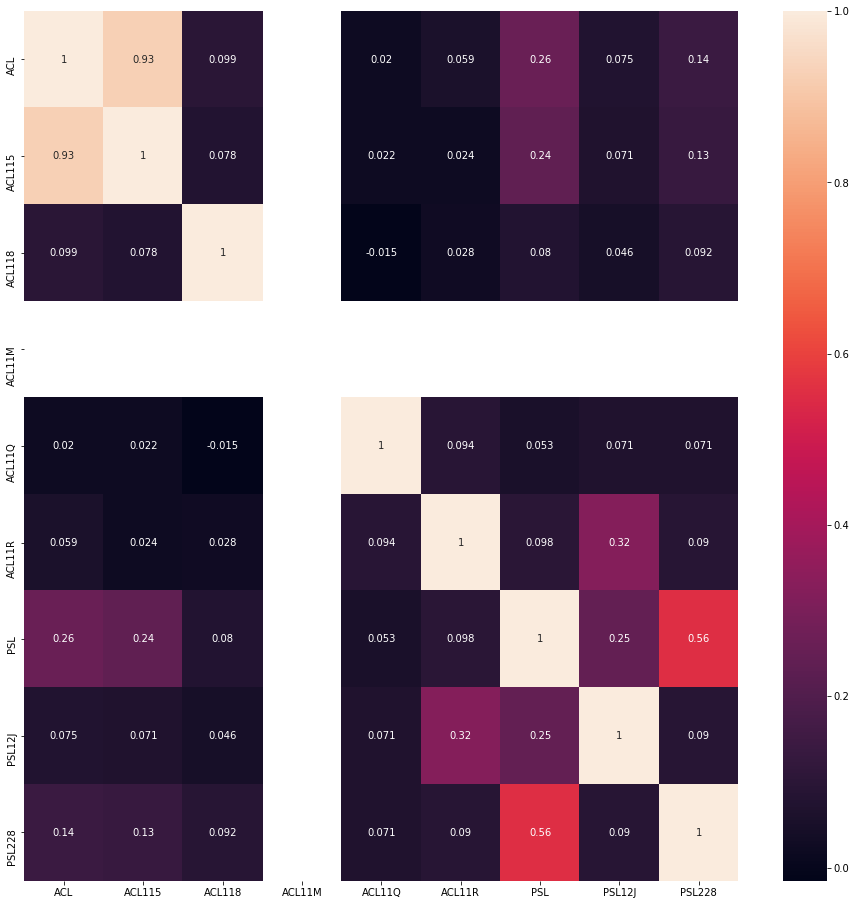

In [10]:
variablesLargo = ['ACL', 'ACL115','ACL118','ACL11M','ACL11Q','ACL11R','PSL', 'PSL12J', 'PSL228']
corr_plot(removeAllOutliers(ejercicios,variablesLargo), variablesLargo)

En ACL11M (propiedad de inversión) no hay suficientes instancias después de corregir los outliers como para que tenga valor, por lo que esta variable se puede ignorar.

Solo el activo no corriente está relacionada con las propiedades de planta y equipo, seguramente porque representan la mayor parte del activo a largo.

También se examinan las variables que forman el patrimonio.

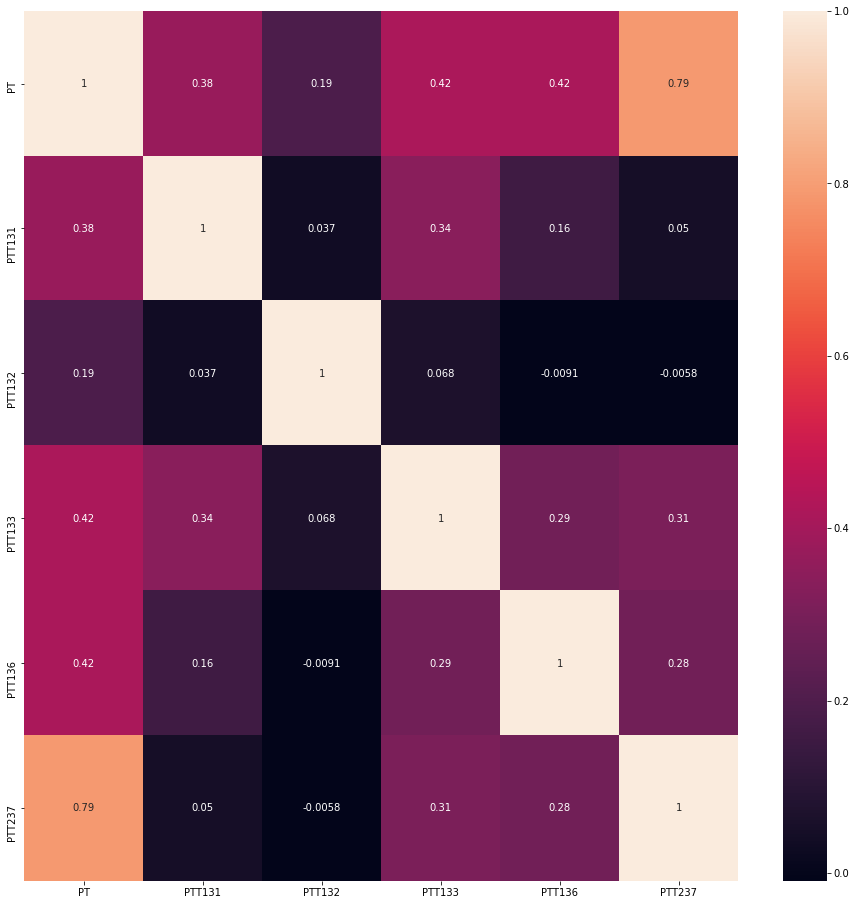

In [11]:
variablesPT = ['PT','PTT131', 'PTT132','PTT133','PTT136','PTT237']
corr_plot(removeAllOutliers(ejercicios,variablesPT), variablesPT)

La única observación relevante es que las ganancias acumuladas son la mayor representación del patrimonio, ya que presentan una correlación más alta que el resto de variables.

Por último, se examinan los resultados de los ejercicios en su forma de ingresos y gastos:

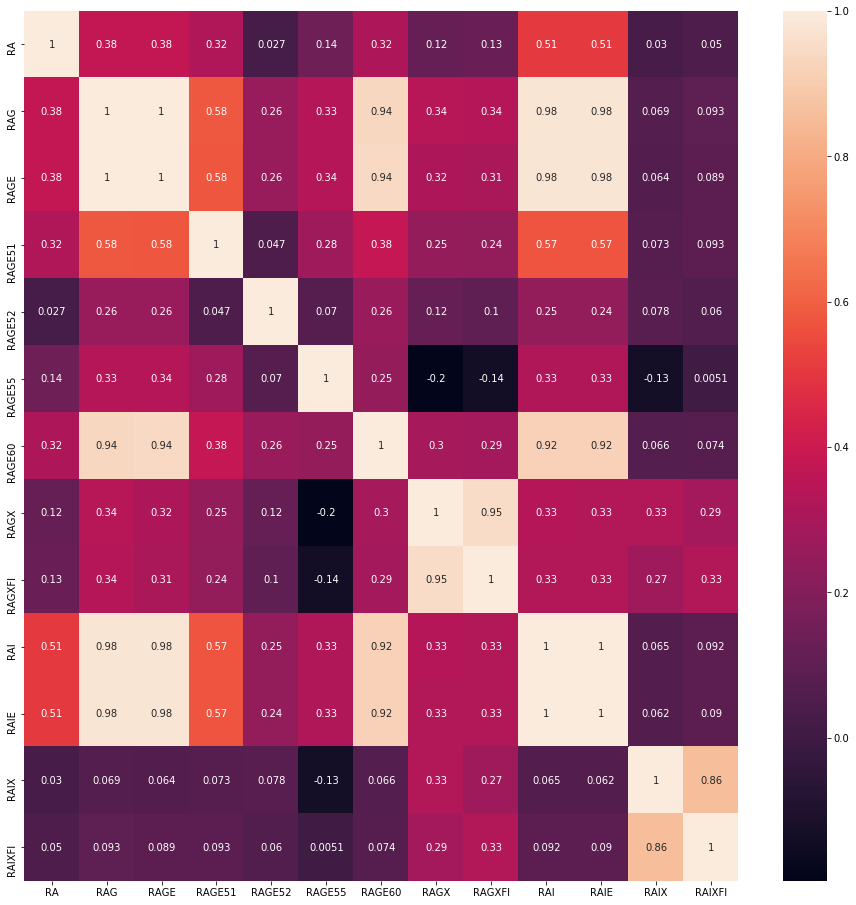

In [12]:
variablesRA = ['RA','RAG', 'RAGE','RAGE51','RAGE52','RAGE55', 'RAGE60','RAGX','RAGXFI','RAI','RAIE','RAIX','RAIXFI']
corr_plot(removeAllOutliers(ejercicios,variablesRA), variablesRA)

Se observa que:

* RAI y RAG están estrictamente relacionadas. Lo que significa que cuando suben los ingresos suben los costes y cuando bajan también actúan en consecuencia.
* RAG y RAGE presentan alta correlación, por lo que gran parte de los gastos son operacionales en las empresas.
* RAI y RAIE también presentan el mismo síntoma. Esto significa que la mayor parte de los ingresos son los operacionales en las empresas.
* Por lo tanto, todas esas 6 variables presentan una alta correlación entre ellas. (RAI con RAGE y RAG con RAIE, adicionalmente).
* RAI y RAGE60 están altamente relacionadas. Esto significa que la mayor parte de los costos procede de las ventas.
* RAX y RAXFI están muy relacionadas. Significa que los gastos no operacionales proceden de los financieros y por lo tanto del interés del crédito.
* También sucede lo mismo con RAIX y RAIXFI, que son los ingresos no operacionales y los financieros.

Por lo tanto, se pueden descartar las variables con alta correlación, dejando solo la más representativa. En resumen:

1. RAIX y RAGX se eliminan en favor de su parte financiera, ya que una de estas variables financieras es utilizada para etiquetar las empresas como zombis.
2. Se conservan RAGE51,52,53,60 y RAIE como representantes de los costos y los ingresos. Se eliminan RAG, RAGE y RAI.
3. Se conservan todas las variables del patrimonio.
4. Se eliminan ACL11M, ACL115, ACC113, PSC223 ya que se pueden representar con los totales del activo y pasivo corriente y no corriente. ACL11M se elimina porque tiene demasiados valores a 0.
5. Se prescinde de RIII, ya que es función del resultado del ejercicio (RA).
6. RAGE52: Demasiadas filas sin informar. (a 0).

Estas columnas se eliminarán a posteriori, ya que primero de todo se mira de corregir los datos erróneos según definición.

### Tratamiento de valores erróneos
Aunque por definición, no se puede asumir que exista ningún valor perdido, ya que las celdas perdidas en el dataset representan ganancias y gastos no realizados (0), sí que es posible que existan valores erróneos.

Esto se puede comprobar fácilmente a través de las fórmulas que calculan las variables agregadas. Se realizan las siguientes comprobaciones:

* AC = ACC + ACL
* PS = PSC + PSL
* P = PS + PT
* R = RA - RIII
* ACC >= ACC13 + ACC114 + ACC118 + ACC11H + ACC211
* ACL >= ACL115 + ACL118 + ACL11M + ACL11Q + ACL11R
* PSC >= PSC223 + PSC224 + PSC225 + PSC228
* PSL >= PSL12J + PSL228

Las inecuaciones se deben a que pueden faltar conceptos por informar, y no es adecuado utilizar la igualdad como condición. Si se incumple la inecuación, es completamente seguro que se trata de un error.

En primer lugar se realiza una pequeña prueba con los activos, para verificar cuáles son las propiedades de las filas que no cumplen la condición:

In [13]:
# Realizar la operación de resta para determinar aquellas filas con el importe incorrecto 
ejercicios['TestAC'] = abs(ejercicios['AC'] - (ejercicios['ACC'] + ejercicios['ACL']))
# Cuál es la máxima desviación de las filas?
print("La desviación máxima respecto a la fórmula es: {0} ".format(ejercicios[ejercicios['TestAC'] != 0]['TestAC'].max()))
# Ver una fila que presente una diferencia distinta a 0
print("Valor de la suma entre ACC y ACL:")
print(ejercicios[ejercicios['TestAC'] != 0].iloc[0,:]['ACC'] + ejercicios[ejercicios['TestAC'] != 0].iloc[0,:]['ACL'])
print("Valor de AC:")
print(ejercicios[ejercicios['TestAC'] != 0].iloc[0,:]['AC'])

La desviación máxima respecto a la fórmula es: 1.0 
Valor de la suma entre ACC y ACL:
23814578.5052
Valor de AC:
23814578.505200002


Por lo tanto, las filas que no cumplen la condición son causadas por pequeñas diferencias en los decimales. La variable AC no contiene datos erróneos.

Se ponen a prueba las otras considerando que pueden aparecer estas pequeñas diferencias en los decimales:

In [14]:
# Realizar la operación de resta para determinar aquellas filas con el importe incorrecto 
ejercicios['TestPS'] = abs(ejercicios['PS'] - (ejercicios['PSC'] + ejercicios['PSL']))
print("Número de filas erróneas para PS (Pasivo): {0}".format(ejercicios[ejercicios['TestPS'] > 1]['TestPS'].count()))

ejercicios['TestP'] = abs(ejercicios['P'] - (ejercicios['PS'] + ejercicios['PT']))
print("Número de filas erróneas para P (Patrimonio): {0}".format(ejercicios[ejercicios['TestP'] > 1]['TestP'].count()))

ejercicios['TestR'] = abs(ejercicios['R'] - (ejercicios['RA'] - ejercicios['RIII']))
print("Número de filas erróneas para R (Utilidad neta): {0}".format(ejercicios[ejercicios['TestR'] > 1]['TestR'].count()))

Número de filas erróneas para PS (Pasivo): 0
Número de filas erróneas para P (Patrimonio): 0
Número de filas erróneas para R (Utilidad neta): 56


In [15]:
# Ver las estadísticas básicas de aquellos resultados cuya utilidad neta no equivale a la bruta menos los impuestos
ejercicios[ejercicios['TestR'] > 1]['TestR'].describe()

count    5.600000e+01
mean     4.938106e+07
std      3.220687e+08
min      1.621080e+02
25%      2.770167e+04
50%      1.715785e+05
75%      1.791908e+06
max      2.407248e+09
Name: TestR, dtype: float64

Existen unas pocas empresas donde la utilidad neta no coincide con la bruta menos los impuestos. Se corrige la columna de los impuestos para que esté en acorde con la diferencia entre la utilidad neta y bruta.

In [16]:
ejercicios['RIIIUpdated'] = ejercicios['RIII']
ejercicios.loc[ejercicios['TestR'] > 1,'RIIIUpdated'] = ejercicios[ejercicios['TestR'] > 1]['RA'] - ejercicios[ejercicios['TestR'] > 1]['R']
ejercicios['TestR2'] = abs(ejercicios['R'] - (ejercicios['RA'] - ejercicios['RIIIUpdated']))
print("Número de filas erróneas para R (Utilidad neta) después de la corrección: {0}".format(ejercicios[ejercicios['TestR2'] > 1]['TestR2'].count()))

Número de filas erróneas para R (Utilidad neta) después de la corrección: 0


In [17]:
# Actualizar RIII con las correcciones
ejercicios['RIII'] = ejercicios['RIIIUpdated']

Y se ponen a prueba el resto de variables.

In [18]:
# Prueba de ACC
ejercicios['TestACC'] = ejercicios['ACC'] - (ejercicios['ACC113'] + ejercicios['ACC114'] + ejercicios['ACC118'] + ejercicios['ACC11H'] + ejercicios['ACC211'])
print("Número de filas erróneas para ACC (Activo corriente): {0}".format(ejercicios[ejercicios['TestACC'] < -1]['TestACC'].count()))

# Prueba de ACL
ejercicios['TestACL'] = ejercicios['ACL'] - (ejercicios['ACL115'] + ejercicios['ACL118'] + ejercicios['ACL11M'] + ejercicios['ACL11Q'] + ejercicios['ACL11R'])
print("Número de filas erróneas para ACL (Activo no corriente): {0}".format(ejercicios[ejercicios['TestACL'] < -1]['TestACL'].count()))

# Prueba de PSC
ejercicios['TestPSC'] = ejercicios['PSC'] - (ejercicios['PSC223'] + ejercicios['PSC224'] + ejercicios['PSC225'] + ejercicios['PSC228'])
print("Número de filas erróneas para PSC (Pasivo corriente): {0}".format(ejercicios[ejercicios['TestPSC'] < -1]['TestPSC'].count()))

# Prueba de PSL
ejercicios['TestPSL'] = ejercicios['PSL'] - (ejercicios['PSL12J'] + ejercicios['PSL228'])
print("Número de filas erróneas para PSL (Pasivo no corriente): {0}".format(ejercicios[ejercicios['TestPSL'] < -1]['TestPSL'].count()))

Número de filas erróneas para ACC (Activo corriente): 0
Número de filas erróneas para ACL (Activo no corriente): 0
Número de filas erróneas para PSC (Pasivo corriente): 0
Número de filas erróneas para PSL (Pasivo no corriente): 0


Aunque muchas de las variables pueden tomar un valor negativo (por ejemplo, el impuesto de sociedades puede ser negativo cuando los beneficios de la empresa son negativos, de esta forma pudiendo compensar los balances en los futuros ejercicios), puede no resultar adecuado trabajar con estos valores.

El principal motivo son las posibles transformaciones que se pueden aplicar a los datos. Es posible que se tengan que calcular variaciones entre variables o ejercicios, por lo que los valores negativos pueden introducir interpretaciones erróneas en esas transformaciones.

Por lo tanto, si la presencia de valores negativos en una variable aporta poco valor de cara al análisis, se puede optar por prescindir de aquellas filas con importes negativos, siempre y cuando no perturbe la integridad.

También se descartan las empresas con patrimonio negativo, ya que en posteriores análisis se trabaja con variaciones del patrimonio y las instancias negativas perturban los resultados.

La utilidad neta puede ser negativa y refleja pérdidas en el ejercicio, por lo que las filas con importe negativo se deben considerar.

In [19]:
def print_negatives(df, variable):
    num = df[df[variable] < 0][variable].count() 
    if (num > 0):
        print("La variable {0} tiene {1} valores negativos".format(variable, num))
    else:
        print("La variable {0} no tiene valores negativos".format(variable))

variables_sinnegativos = ['AC','ACC','ACC113','ACC114','ACC118','ACC11H','ACC211',\
                         'ACL','ACL115','ACL118','ACL11M','ACL11Q','ACL11R',\
                         'PS','PSC','PSC223','PSC224','PSC225','PSC228','PTT131','PTT132','PTT133',\
                         'RAG','RAGE','RAGE51','RAGE52','RAGE55','RAGE60','RAGX','RAGXFI',
                         'RAI','RAIE','RAIX','RAIXFI','PT']

for var in variables_sinnegativos:
    print_negatives(ejercicios, var)

La variable AC no tiene valores negativos
La variable ACC no tiene valores negativos
La variable ACC113 no tiene valores negativos
La variable ACC114 no tiene valores negativos
La variable ACC118 no tiene valores negativos
La variable ACC11H no tiene valores negativos
La variable ACC211 no tiene valores negativos
La variable ACL tiene 1 valores negativos
La variable ACL115 no tiene valores negativos
La variable ACL118 no tiene valores negativos
La variable ACL11M no tiene valores negativos
La variable ACL11Q tiene 1 valores negativos
La variable ACL11R tiene 1 valores negativos
La variable PS no tiene valores negativos
La variable PSC no tiene valores negativos
La variable PSC223 no tiene valores negativos
La variable PSC224 no tiene valores negativos
La variable PSC225 no tiene valores negativos
La variable PSC228 tiene 1 valores negativos
La variable PTT131 tiene 35 valores negativos
La variable PTT132 no tiene valores negativos
La variable PTT133 tiene 286 valores negativos
La varia

Las filas de todas las variables que presenten números negativos serán eliminadas.

No se eliminarán los negativos del **patrimonio**. Aunque son pocos, un patrimonio negativo significa un resultado del ejercicio con pérdidas, que no puede ser asumido por los activos.

Esta es precisamente la definición zombi extrema, cuando el pasivo es superior al activo, ya que AC = PS + PT. Por lo que si es negativo AC + PT = PS y por lo tanto AC < PS.

Las filas con patrimonio negativo se conservarán, por el momento.

In [20]:
def actualizarFilasNegativas(df, variable):
    return df[df[variable] >= 0]

# Se quitan los valores negativos de todas las columnas salvo el patrimonio
for var in [v for v in variables_sinnegativos if v not in ['PT']]:
    ejercicios = actualizarFilasNegativas(ejercicios, var)

Algunas variables tampoco tiene sentido que sean 0, salvo para algunos tipos de empresa que no sean de interés (sin ánimo de lucro o similares), por lo que también se eliminan las empresas que presenten alguna de las siguientes variables a 0.

In [21]:
def print_conceros(df, variable):
    num = df[df[variable] == 0][variable].count() 
    if (num > 0):
        print("La variable {0} tiene {1} valores igual a 0".format(variable, num))
    else:
        print("La variable {0} no tiene valores igual a 0".format(variable))
        
# Variables que no tienen sentido si presentan el valor 0
variables_sinceros = ['AC','ACC','PS','PSC','RAG','RAGE','RAI','RAIE']

for var in variables_sinceros:
    print_conceros(ejercicios, var)

La variable AC no tiene valores igual a 0
La variable ACC tiene 4 valores igual a 0
La variable PS tiene 18 valores igual a 0
La variable PSC tiene 68 valores igual a 0
La variable RAG tiene 36 valores igual a 0
La variable RAGE tiene 43 valores igual a 0
La variable RAI tiene 41 valores igual a 0
La variable RAIE tiene 91 valores igual a 0


In [22]:
def actualizarFilasCeros(df, variable):
    return df[df[variable] != 0]

for var in variables_sinceros:
    ejercicios = actualizarFilasCeros(ejercicios, var)

Estas son todas las correcciones que se consideran por el momento en los datasets de ejercicios.

Ahora sí, se eliminan las variables redundantes que se han detectado mediante el análisis de correlaciones.

In [23]:
vars_eliminar = ['RAIX','RAGX','RAE','RAG','RAGE','RAGX','RAI','RAIX','RAX','RAXFI','R','RIII','PTT136','P','RAGE52','ACL11M']
vars_test = ['TestPS','TestP','TestR','RIIIUpdated','TestR2','TestAC','TestACC','TestACL','TestPSC','TestPSL']
ejercicios_drop = ejercicios.drop(vars_eliminar + vars_test,axis=1)
# Ver aquellas variables que no son cero.
ejercicios_drop[ejercicios_drop != 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39541 entries, 0 to 13356
Data columns (total 35 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      39541 non-null  int64  
 1   AC      39541 non-null  float64
 2   ACC     39541 non-null  float64
 3   ACC11H  23142 non-null  float64
 4   ACC113  38877 non-null  float64
 5   ACC114  27438 non-null  float64
 6   ACC118  20392 non-null  float64
 7   ACC211  39360 non-null  float64
 8   ACL     39107 non-null  float64
 9   ACL11Q  13253 non-null  float64
 10  ACL11R  17426 non-null  float64
 11  ACL115  37385 non-null  float64
 12  ACL118  15196 non-null  float64
 13  PS      39541 non-null  float64
 14  PSC     39541 non-null  float64
 15  PSC223  38795 non-null  float64
 16  PSC224  33379 non-null  float64
 17  PSC225  25496 non-null  float64
 18  PSC228  30467 non-null  float64
 19  PSL     32439 non-null  float64
 20  PSL12J  18959 non-null  float64
 21  PSL228  20277 non-null  float64
 22

In [24]:
# Guardar los ejercicios limpios
ejercicios_drop.to_csv("data/EjerciciosClean.csv",sep=";",index=False)
ejercicios = ejercicios_drop

### Transformación de variables
La transformación de las variables tiene como objetivo incrementar el valor de los datos para que sea el máximo posible de cara al proceso de modelado de los algoritmos.

Los datos de ejercicios fiscales de las empresas presentan las siguientes características:

* Son muy descompensados. Las diferencias entre grandes y pequeñas empresas son abismales. Prácticamente todas las grandes empresas tendrán datos financieros que se podrían considerar outliers en su totalidad.
* Las distribuciones suelen ser exponenciales, aunque hay mucha variedad, como se ha visto en anteriores apartados.

Un aspecto importante a tener en cuenta es que en análisis financiero se centra en las relaciones entre variables más que en los valores absolutos de las partidas (por ejemplo, no se suele comparar el activo de varias empresas, sino su relación con otras partidas). Estas variables relacionadas también son llamadas [indicadores financieros clave](https://incp.org.co/analisis-financiero-mediante-indicadores-para-la-toma-de-decisiones/). Los indicadores permiten comparar distintas empresas de manera más efectiva.

Se propone utilizar estos indicadores financieros en el dataset como vía para enriquecer los datos. Además, algunos de estos indicadores han sido utilizados en estudios anteriores para caracterizar las empresas zombis, por lo que su inclusión está más que justificada.

Algunos de los indicadores financieros de rentabilidad más conocidos y calculables en este dataset son:

* MargenNeto: proporción de beneficios entre ventas de la empresa. Es una medida de rentabilidad. Se puede calcular como RA/RAIE
* ROE: Return on equity. Proporción entre los beneficios y el patrimonio neto. Indica la rentabilidad financiera de cara a los socios de la empresa. Se calcula como RA/PT
* ROA: Return on assets. Proporción entre los beneficios y el valor de los activos. Es una medida de rentablidad. Se calcula como RA/ROA

Por la otra parte, también existen indicadores de endeudamiento que se pueden calcular:

* Leverage: Apalancamiento total. Proporción entre las obligaciones de la empresa y su patrimonio neto. Indica la capacidad de afrontar la deuda con los fondos propios de la empresa. Se calcula como PS/PT. A mayor valor, más apalancamiento y por lo tanto más difícil resulta afrontar la deuda.
* Leverage a corto: PSC / PT
* Leverage a largo: PSL / PT
* Endeudamiento: PS / AC. Cuanto representa la deuda respecto a los activos de la empresa.
* Concentración a corto plazo: PSC / PS. Como de concentrada se encuentra la deuda a corto respecto al total de la deuda.
* Endeudamiento financiero: PS / RAIE. Deuda respecto a los ingresos del ejercicio.

Además, es posible crear relaciones propias de parte/total en algunas de las variables del dataset. Por ejemplo, calcular, en una empresa, qué parte de su activo corriente corresponde a las deudas de terceros con la empresa. Esto se realiza para todas las partes del activo y del pasivo.

In [25]:
# Indicadores de rentabilidad
ejercicios['MargenNeto'] = ejercicios['RA'] / ejercicios['RAIE']
ejercicios['ROE'] = ejercicios['RA'] / ejercicios['PT']
ejercicios['ROA'] = ejercicios['RA'] / ejercicios['AC']

# Indicadores de endeudamiento
ejercicios['Apalanc'] = ejercicios['PS'] / ejercicios['PT']
ejercicios['ApalancCorto'] = ejercicios['PSC'] / ejercicios['PT']
ejercicios['ApalancLargo'] = ejercicios['PSL'] / ejercicios['PT']
ejercicios['Endeudamiento'] = ejercicios['PS'] / ejercicios['AC']
ejercicios['ConcentracionCorto'] = ejercicios['PSC'] / ejercicios['PS']
ejercicios['EndeudamientoFinanciero'] = ejercicios['PS'] / ejercicios['RAIE']

# Indicadores de proporción en activos y pasivos corrientes y no corrientes
ejercicios['RelActivoCortoDeutores'] = ejercicios['ACC113'] / ejercicios['ACC']
ejercicios['RelActivoCortoInventarios'] = ejercicios['ACC114'] / ejercicios['ACC']
ejercicios['RelActivoCortoEfectivo'] = ejercicios['ACC211'] / ejercicios['ACC']
ejercicios['RelActivoCortoOtros'] = ejercicios['ACC118'] / ejercicios['ACC']
ejercicios['RelActivoCortoImpuestos'] = ejercicios['ACC11H'] / ejercicios['ACC']

ejercicios['RelActivoLargoOtros'] = ejercicios['ACL118'] / ejercicios['ACL']
ejercicios['RelActivoLargoPropiedades'] = ejercicios['ACL115'] / ejercicios['ACL']
ejercicios['RelActivoLargoImpuestos'] = ejercicios['ACL11R'] / ejercicios['ACL']
ejercicios['RelActivoLargoIntangibles'] = ejercicios['ACL11Q'] / ejercicios['ACL']

ejercicios['RelPasivoCortoPagar'] = ejercicios['PSC223'] / ejercicios['PSC']
ejercicios['RelPasivoCortoImpuestos'] = ejercicios['PSC224'] / ejercicios['PSC']
ejercicios['RelPasivoCortoProvisiones'] = ejercicios['PSC225'] / ejercicios['PSC']
ejercicios['RelPasivoCortoOtros'] = ejercicios['PSC228'] / ejercicios['PSC']

ejercicios['RelPasivoLargoImpuestos'] = ejercicios['PSL12J'] / ejercicios['PSL']
ejercicios['RelPasivoLargoOtros'] = ejercicios['PSL228'] / ejercicios['PSL']

# Ignorar 
ejercicios[ejercicios == np.inf] = 0
ejercicios[ejercicios == -np.inf] = 0
ejercicios = ejercicios.fillna(0)

La mayoría de indicadores caerá dentro del rango {0,1}, ya que tienen como numerador la parte y como denominador el total. 

Existe un problema, y es que se pueden dar dos situaciones difíciles de controlar:

1. Puede ser que un numerador sea 0, ya que esa empresa tiene esa partida a 0.
2. Puede ser que un denominador sea 0, por el mismo motivo. Esto solo puede pasar en pocos casos.

En el primer caso, no es posible determinar cúal es el valor correcto para la relación, ya que si la parte es cero, no existe esa relación. Lo indicado sería dejar el valor vacío.

Pero a su vez, como se ha visto en la inspección de variables, existen muchas variables con pocos valores. Asignar esos valores a perdidos puede comprometer la integridad del dataset.

Se inspecciona cuantos valores realmente se encuentran a cero para las variables de indicadores financieros creadas.

In [26]:
variablesIndicadores = ['MargenNeto','ROE','ROA','Apalanc','ApalancCorto','ApalancLargo',\
                        'Endeudamiento','ConcentracionCorto','EndeudamientoFinanciero',\
                        'RelActivoCortoDeutores','RelActivoCortoInventarios',\
                        'RelActivoCortoEfectivo','RelActivoCortoOtros','RelActivoCortoImpuestos',\
                        'RelActivoLargoOtros',\
                        'RelActivoLargoPropiedades','RelActivoLargoImpuestos',\
                        'RelActivoLargoIntangibles','RelPasivoCortoPagar',\
                        'RelPasivoCortoImpuestos','RelPasivoCortoProvisiones','RelPasivoCortoOtros',\
                        'RelPasivoLargoImpuestos','RelPasivoLargoOtros']

test_ceros = ejercicios[variablesIndicadores]
print("Proporción de instancias a cero de los indicadores financieros:")
test_ceros[test_ceros == 0].count() / test_ceros.count()

Proporción de instancias a cero de los indicadores financieros:


MargenNeto                   0.000025
ROE                          0.000025
ROA                          0.000025
Apalanc                      0.000000
ApalancCorto                 0.000000
ApalancLargo                 0.179611
Endeudamiento                0.000000
ConcentracionCorto           0.000000
EndeudamientoFinanciero      0.000000
RelActivoCortoDeutores       0.016793
RelActivoCortoInventarios    0.306087
RelActivoCortoEfectivo       0.004578
RelActivoCortoOtros          0.484282
RelActivoCortoImpuestos      0.414734
RelActivoLargoOtros          0.615690
RelActivoLargoPropiedades    0.054526
RelActivoLargoImpuestos      0.559293
RelActivoLargoIntangibles    0.664829
RelPasivoCortoPagar          0.018866
RelPasivoCortoImpuestos      0.155838
RelPasivoCortoProvisiones    0.355201
RelPasivoCortoOtros          0.229483
RelPasivoLargoImpuestos      0.520523
RelPasivoLargoOtros          0.487191
dtype: float64

Se considera llevar a cabo una discretización de datos para aquellas variables que tengan muchas instancias a cero. En primer lugar, se observan las distribciones de las variables creadas:

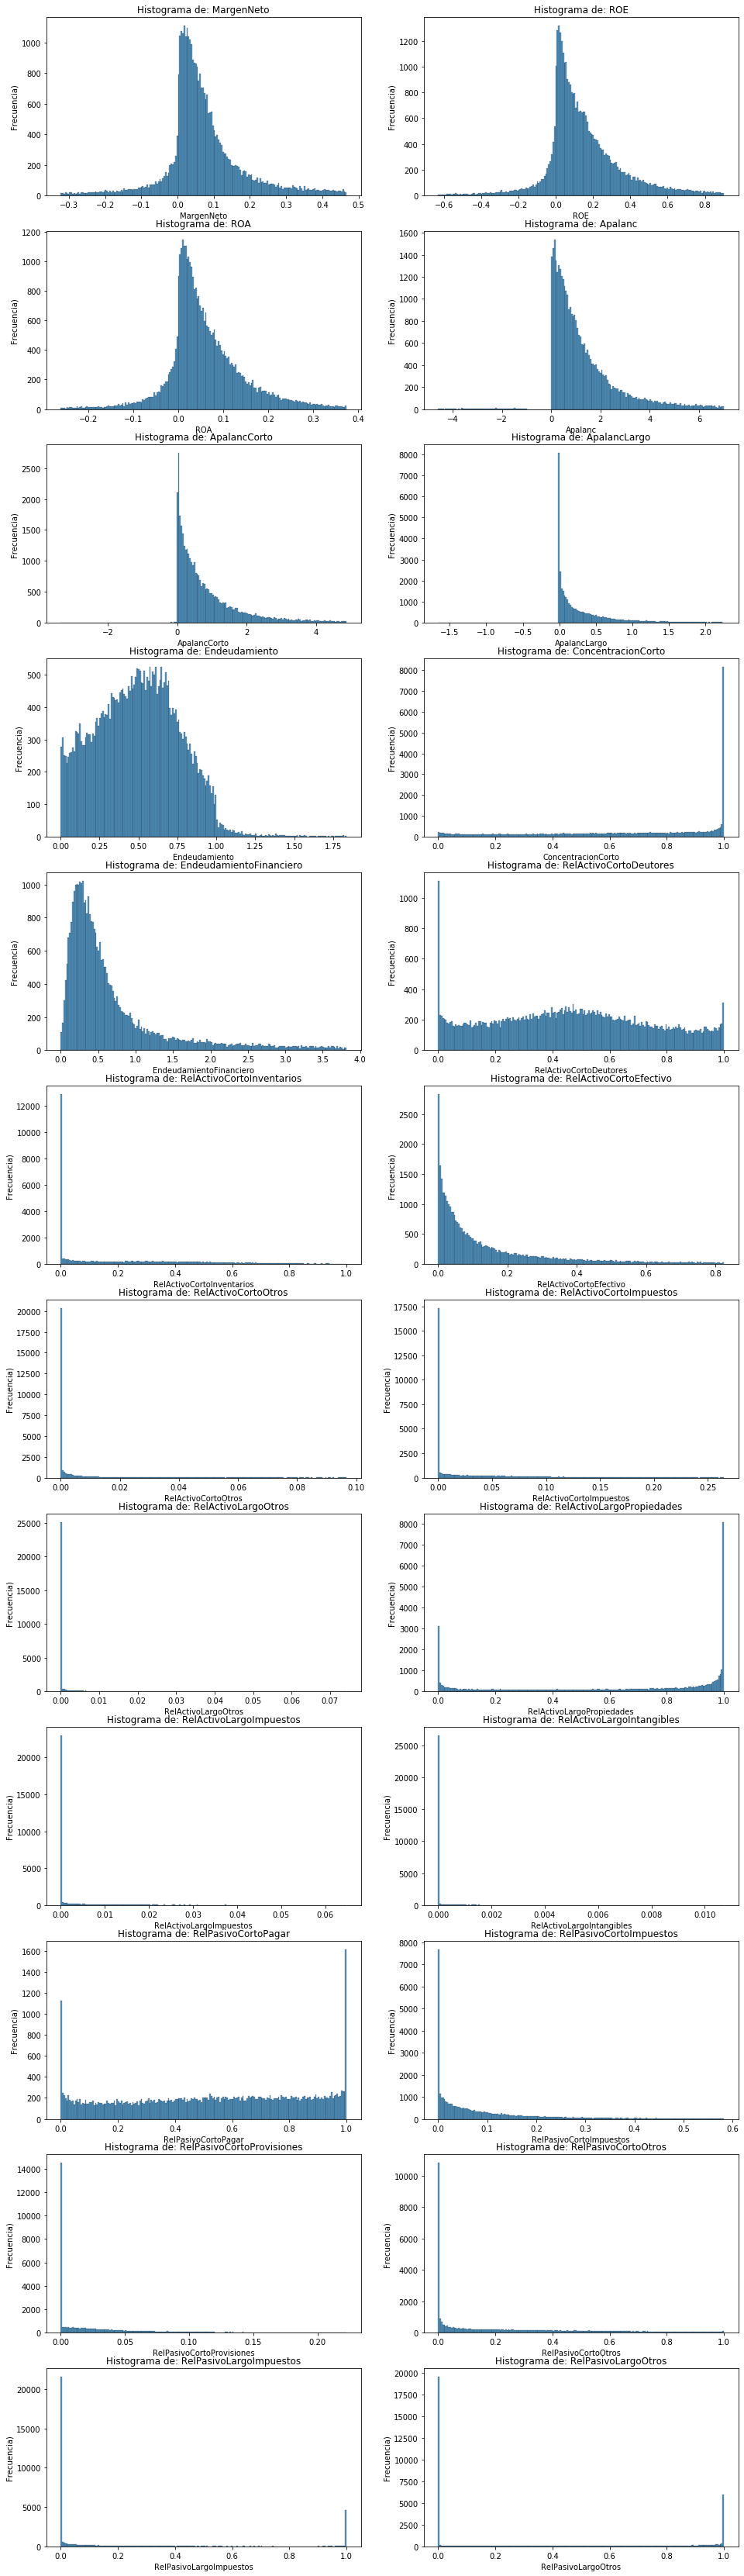

In [27]:
def internal_plotVariables(df, variables, func):
    numCols = 2
    numRows = math.ceil(len(variables) / 2)
    figSize = numRows * 5
    # Construir las visualizaciones con los histogramas de las principales variables fiscales
    fig, axes = plt.subplots(numRows,numCols, figsize=(16,figSize))
    for i, v in enumerate(variables):
        row = int(i / numCols)
        col = i % numCols
        plot_hist_fiscal_normal(func(df,v), v, v, row, col, axes)
        
    if (len(variables) < numCols * numRows):
        axes[numRows-1,numCols-1].axis('off')
        
    plt.show()
    
def plotVariables(df, variables):
    internal_plotVariables(df, variables, lambda x,y: remove_outliers(x,y))
    
def plotVariablesAll(df, variables):
    internal_plotVariables(df, variables, lambda x,y: x)
    
plotVariables(ejercicios, variablesIndicadores)

Las siguientes variables no se deben discretizar, ya que presentan distribuciones definidas:

* MargenNeto
* ROE
* ROA
* Autonomía / AutonomíaCorto / AutonomíaLargo
* Endeudamiento
* EndeudamientoFinanciero.

Las instancias que no se han podido calcular, ya que el numerador del ratio era 0 son bastantes. Se decide que si alguna variable supera el 5% de valores sin calcular, esta será categorizada.

Las categorías creadas serán las siguientes:

* 0: Categoría que agrupa todos los valores que son 0. Esta categoría representan los ratios que no se han podido calcular, ya que la empresa no tenía la partida informada.
* 1-N: Se crean N categorías de datos separando los grupos según la proporción que la variable represente del total. Por ejemplo, si sus activos de inventarios son 300 y su activo corriente es 600, tendrá un valor de 0.5 que será discretizado a 2.
    * Si su valor es 0; se discretiza como 0.
    * Si su relación es entre 0 y 0.3 se discretiza como 1.
    * Entre 0.3 y 0.7; como 2.
    * Entre 0.7 y 1; como 3.

La variable resultante será ordinal, ya que existirá un orden entre sus categorías.

In [28]:
# Seleccionar únicamente las variables que presentan un número alto de ceros.
discretizar = test_ceros[test_ceros == 0].count() / test_ceros.count() > 0.05
colNamesDiscretizar = discretizar[discretizar == True].index.tolist()

colNamesDiscretizar = [c for c in colNamesDiscretizar if c not in \
    ['MargenNeto','ROE','ROA','Apalanc','ApalancCorto','ApalancLargo',\
     'Endeudamiento','EndeudamientoFinanciero']]

discretized = ejercicios

for v in colNamesDiscretizar:
    # Crear las categorías según la fórmula establecida
    discretized[v + "_CAT"] = pd.cut(discretized[v], bins=[-np.inf,0, 0.3, 0.7, np.inf], labels=False, duplicates='drop')

Se verifica que los valores se hayan discretizado correctamente mediante un scatterplot. La visualización debería salir escalonada según el valor de la relación.

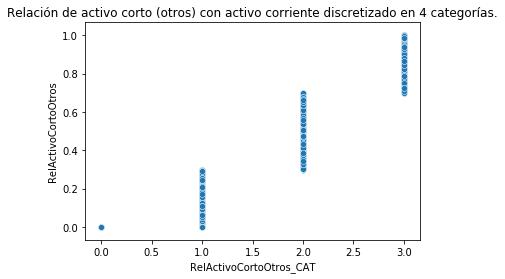

In [29]:
# Observar el scatterplot
sns.scatterplot(x=discretized['RelActivoCortoOtros_CAT'],y=discretized['RelActivoCortoOtros'])
plt.title("Relación de activo corto (otros) con activo corriente discretizado en 4 categorías.")
plt.show()

Aquellas columnas que se hayan discretizado se eliminan del dataset.

In [30]:
ejercicios_discretized = discretized.drop(colNamesDiscretizar,axis=1)
ejercicios_discretized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39541 entries, 0 to 13356
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             39541 non-null  int64  
 1   AC                             39541 non-null  float64
 2   ACC                            39541 non-null  float64
 3   ACC11H                         39541 non-null  float64
 4   ACC113                         39541 non-null  float64
 5   ACC114                         39541 non-null  float64
 6   ACC118                         39541 non-null  float64
 7   ACC211                         39541 non-null  float64
 8   ACL                            39541 non-null  float64
 9   ACL11Q                         39541 non-null  float64
 10  ACL11R                         39541 non-null  float64
 11  ACL115                         39541 non-null  float64
 12  ACL118                         39541 non-null 

A continuación, se complementa el dataset generado hasta el momento con un análisis dinámico de los ejercicios.

El análisis dinámico incorpora variables que representan la evolución de los resultados a través de los ejercicios. Por ejemplo, la variación del activo corriente desde el 2017 hacia el 2019.

Así pues, de cara a la fase de creación y evaluación de modelos de aprendizaje automático, se plantea el uso de nuevas variables de transformación que representen variaciones entre los ejercicios.

En este sentido la actividad que se realiza es similar al [análisis horizontal](https://www.bursitia.com/2020/10/20/como-hacer-un-analisis-horizontal-de-los-estados-financieros/) de los datos financieros de las empresas. Considerando la creación de las siguientes variables transformadas:

1. Variación absoluta del dato financiero entre el ejercicio 2017 al 2019
2. Variación absoluta del dato financiero entre el ejercicio 2018 y 2019
3. Variación relativa (o porcentual) entre el ejercicio el 2019 y el 2017.

Después de experimentar la creación de estos tres tipos de variables en el dataset, se determina que **todos** los tres tipos presentan una alta correlación (este estudio se omite del cuaderno). Por lo tanto, se elige preservar la variación que aporta un menor número de valores atípicos: **la variación relativa**.

La variación relativa representa el número de veces que ha mejorado o empeorado una partida respecto al 2017. Es una variable que oscila entre números negativos y positivos de bajo alcance (salvo algunas empresas), por lo que su interpretación es más simple.

Esta variación relativa se aplicará bajo una selección (no todas) de las variables originales financieras.

También se considera la aplicación de **variaciones absolutas** para las relaciones entre variables y los indicadores de rentabilidad y endeudamiento. Estas variaciones representan una mejora o un deterioro del indicador financiero entre los ejercicios 2017 y 2019.

En primer lugar, antes de todo, se analiza qué variables merecen ser transformadas:

* Para variaciones relativas: Activo, pasivo, activo corriente... Las principales partidas sin llegar al nivel más fino de los activos y pasivos.
* Para variaciones absolutas: los principales indicadores financieros (ROE, endeudamiento) y las relaciones de activos y pasivos creadas anteriormente (las que no hayan sido categorizadas).

In [31]:
# Variables financieras a calcular su variación relativa
variablesFinancierasBasicas = ['AC','ACC','ACL','PS','PSC','PSL','PT','PTT131','PTT133','PTT237','RAGE60','RAIE']
variablesFinancierasBasicasVariacionesRelativas = ["VAR_REL_" + v for v in variablesFinancierasBasicas]

# Indicadores de endeudamiento y relaciones
variablesIndicadoresContinuas = [v for v in variablesIndicadores if v not in colNamesDiscretizar]
variablesIndicadoresVariacionesAbsolutas = ["VAR_ABS_" + v for v in variablesIndicadoresContinuas]
variablesRelacionesDiscretas = [v + "_CAT" for v in colNamesDiscretizar]

def valorEjercicioNoNuloNoCero(resultado):
    if (len(resultado)) == 0:
        return False
    if (resultado.iloc[0] == 0):
        return False
    return True

# Cálculo de las nuevas variables para cada grupo
def calcularVariaciones(group):
    row = dict()
    empresaId = group['ID'].unique()[0]
    row['ID'] = empresaId

    # Variaciones relativas entre partidas financieras (activo, pasivo...)
    for variable in variablesFinancierasBasicas:
        variacionAbsolutaNombre = "VAR_ABS_{0}".format(variable)
        variacionRelativaNombre = "VAR_REL_{0}".format(variable)
        
        resultado2019 = group.loc[group['Anyo'] == 2019,variable]
        resultado2017 = group.loc[group['Anyo'] == 2017,variable]
           
        # Variación relativa
        if (valorEjercicioNoNuloNoCero(resultado2017) and valorEjercicioNoNuloNoCero(resultado2019)):
            variacionRelativa = resultado2019/resultado2017 - 1
            row[variacionRelativaNombre] = variacionRelativa.iloc[0]
        else:
            row[variacionRelativaNombre] = 0          
            
    # Variaciones absolutas entre indicadores y relaciones
    for v in variablesIndicadoresContinuas:
        ind2019 = group.loc[group['Anyo'] == 2019,v]
        if (len(ind2019) > 0):
            valor = ind2019.iloc[0]
            row[v] = valor
        else:
            row[v] = 0
            
            
        ind2017 = group.loc[group['Anyo'] == 2017,v]
        if (len(ind2019) > 0 and len(ind2017) > 0):
            row["VAR_ABS_{0}".format(v)] = ind2019.iloc[0] - ind2017.iloc[0]
        else:
            row["VAR_ABS_{0}".format(v)] = 0
    
    return pd.Series(row)

# Realizar un groupBy ID y aplicar a cada grupo una función para calcular el resultado
ejercicios_transformed = ejercicios_discretized.groupby('ID').apply(calcularVariaciones)
ejercicios_transformed = ejercicios_transformed.reset_index(drop=True)

Al finalizar, se dispone de un dataset con las variaciones entre ejercicios para cada empresa. Esta información puede no ser suficiente, y también se contempla añadir algunas partidas financieras básicas del último ejercicio (2019) en el dataset. 

Se recuerda que las partidas siguen una distribución exponencial, por lo que se normalizan mediante la aplicación del logaritmo. Se suma 1 a cada partida antes de aplicar el logaritmo para que el valor 0 no sea inválido.

La variable PTT237 puede presentar importes negativos, por lo que se decide discretizarla, y no transformar

In [32]:
selectedVarsIndividual = ['ID','ACC','ACL','PSC','PSL','PTT131','PTT133','PTT237','RAGE60','RAIE']
selectedVarsRelations = variablesRelacionesDiscretas + ['ID']
selectedVarsIndividualNoId = [c for c in selectedVarsIndividual if c != 'ID']

ejercicio2019Clean = ejercicios[ejercicios['Anyo'] == 2019][selectedVarsIndividual].copy(deep=True)
ejercicio2019Clean.at[ejercicio2019Clean['PTT237'] < 0,'PTT237'] = np.nan

ejercicio2019Log = pd.concat((ejercicio2019Clean[['ID']],ejercicio2019Clean[selectedVarsIndividualNoId].apply(lambda x: np.log10(x+1))), axis=1)
ejercicios_transformed_merged = ejercicio2019Log.merge(ejercicios_transformed,on="ID",how="left")

ejercicios2019Discretized = ejercicios_discretized[ejercicios_discretized['Anyo'] == 2019][selectedVarsRelations]
ejercicios_transformed_merged = ejercicios_transformed_merged.merge(ejercicios2019Discretized, on="ID",how="left")
# Eliminar filas con resultado negativo en ganancias acumuladas
ejercicios_transformed_merged['PTT237'] = ejercicios_transformed_merged['PTT237'].fillna(-1)
# Discretización deducida visualmente para distribuir los valores de forma equitativa. La variable está normalizada por lo que el logaritmo reduce los outliers
# El valor 0 representa los fondos propios negativos.
ejercicios_transformed_merged['PTT237_CAT'] = pd.cut(ejercicios_transformed_merged['PTT237'], bins=[-np.inf,0, 6, 6.5, 7, np.inf], labels=False, duplicates='drop')
ejercicios_transformed_merged = ejercicios_transformed_merged.drop('PTT237',axis=1)
variablesFinancierasBasicas = [v for v in variablesFinancierasBasicas if v != 'PTT237']
selectedVarsIndividual = [v for v in selectedVarsIndividual if v != 'PTT237']
ejercicios_transformed_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13223 entries, 0 to 13222
Data columns (total 58 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               13223 non-null  int64  
 1   ACC                              13223 non-null  float64
 2   ACL                              13223 non-null  float64
 3   PSC                              13223 non-null  float64
 4   PSL                              13223 non-null  float64
 5   PTT131                           13223 non-null  float64
 6   PTT133                           13223 non-null  float64
 7   RAGE60                           13223 non-null  float64
 8   RAIE                             13223 non-null  float64
 9   VAR_REL_AC                       13223 non-null  float64
 10  VAR_REL_ACC                      13223 non-null  float64
 11  VAR_REL_ACL                      13223 non-null  float64
 12  VAR_REL_PS        

Se observa la distribución final de la variable PTT237_CAT, discretizada para que los fondos propios negativos tengan una categoría propia.

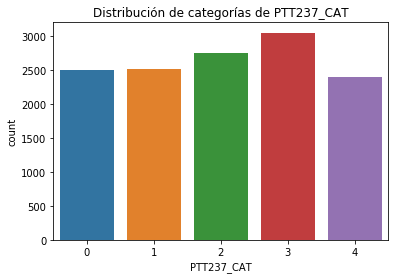

In [33]:
sns.countplot(data=ejercicios_transformed_merged,x='PTT237_CAT')
plt.title("Distribución de categorías de PTT237_CAT")
plt.show()

Una vez se han creado las relaciones entre ejercicios e indicadores, se deben limpiar.

Pueden existir variaciones entre ejercicios anormalmente grandes debido a que algunas empresas crecen exponencialmente entre los períodos. Estas empresas perturban la distribución de las normales al ser exageradamente grandes.

Se puede observar la cantidad de outliers que existen en las variables creadas:

In [34]:
columns_outliers = variablesFinancierasBasicasVariacionesRelativas + variablesIndicadoresContinuas

for c in columns_outliers:
    print("{0} outliers: {1:.2f}%".format(c,(1 - len(remove_outliers(ejercicios_transformed_merged,c)) / len(ejercicios_transformed_merged[c]))*100))

VAR_REL_AC outliers: 3.71%
VAR_REL_ACC outliers: 5.23%
VAR_REL_ACL outliers: 7.57%
VAR_REL_PS outliers: 4.74%
VAR_REL_PSC outliers: 5.10%
VAR_REL_PSL outliers: 10.91%
VAR_REL_PT outliers: 7.00%
VAR_REL_PTT131 outliers: 21.14%
VAR_REL_PTT133 outliers: 12.45%
VAR_REL_PTT237 outliers: 12.92%
VAR_REL_RAGE60 outliers: 6.72%
VAR_REL_RAIE outliers: 6.03%
MargenNeto outliers: 11.70%
ROE outliers: 4.40%
ROA outliers: 2.92%
Apalanc outliers: 6.99%
ApalancCorto outliers: 6.59%
ApalancLargo outliers: 6.77%
Endeudamiento outliers: 0.30%
ConcentracionCorto outliers: 0.00%
EndeudamientoFinanciero outliers: 10.67%
RelActivoCortoDeutores outliers: 0.00%
RelActivoCortoEfectivo outliers: 2.95%
RelPasivoCortoPagar outliers: 0.00%


Las variables con más del 10% de outliers serán eliminadas directamente.

Para los otras variables, los outliers serán asignados a NA. Después de etiquetar se decidirá si preservar o no la variable en función de su importancia.  

In [35]:
columns_outliers = variablesFinancierasBasicasVariacionesRelativas + variablesIndicadoresContinuas + variablesIndicadoresVariacionesAbsolutas 

ejercicios_nooutliers = ejercicios_transformed_merged.copy(deep=True)

# Eliminar la columna
dropOutliers = ['VAR_REL_PTT131','VAR_REL_PTT133','VAR_REL_PTT237','VAR_REL_PSL','MargenNeto']
variablesFinancierasBasicasVariacionesRelativas = [v for v in variablesFinancierasBasicasVariacionesRelativas if v not in dropOutliers]
variablesIndicadores = [v for v in variablesIndicadores if v not in dropOutliers]
variablesIndicadoresContinuas = [v for v in variablesIndicadoresContinuas if v not in dropOutliers]

ejercicios_nooutliers = ejercicios_nooutliers.drop(dropOutliers, axis=1)
columns_outliers = [v for v in columns_outliers if v not in dropOutliers]
# Limpiar outliers
for column in columns_outliers:
    Q1 = ejercicios_nooutliers[column].quantile(0.25)
    Q3 = ejercicios_nooutliers[column].quantile(0.75)
    IQR = Q3 - Q1
    
    ejercicios_nooutliers.loc[(ejercicios_nooutliers[column] < (Q1 - 3 * IQR)) | (ejercicios_nooutliers[column] > (Q3 + 3 * IQR)), column] = np.nan
ejercicios_nooutliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13223 entries, 0 to 13222
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               13223 non-null  int64  
 1   ACC                              13223 non-null  float64
 2   ACL                              13223 non-null  float64
 3   PSC                              13223 non-null  float64
 4   PSL                              13223 non-null  float64
 5   PTT131                           13223 non-null  float64
 6   PTT133                           13223 non-null  float64
 7   RAGE60                           13223 non-null  float64
 8   RAIE                             13223 non-null  float64
 9   VAR_REL_AC                       12732 non-null  float64
 10  VAR_REL_ACC                      12531 non-null  float64
 11  VAR_REL_ACL                      12222 non-null  float64
 12  VAR_REL_PS        

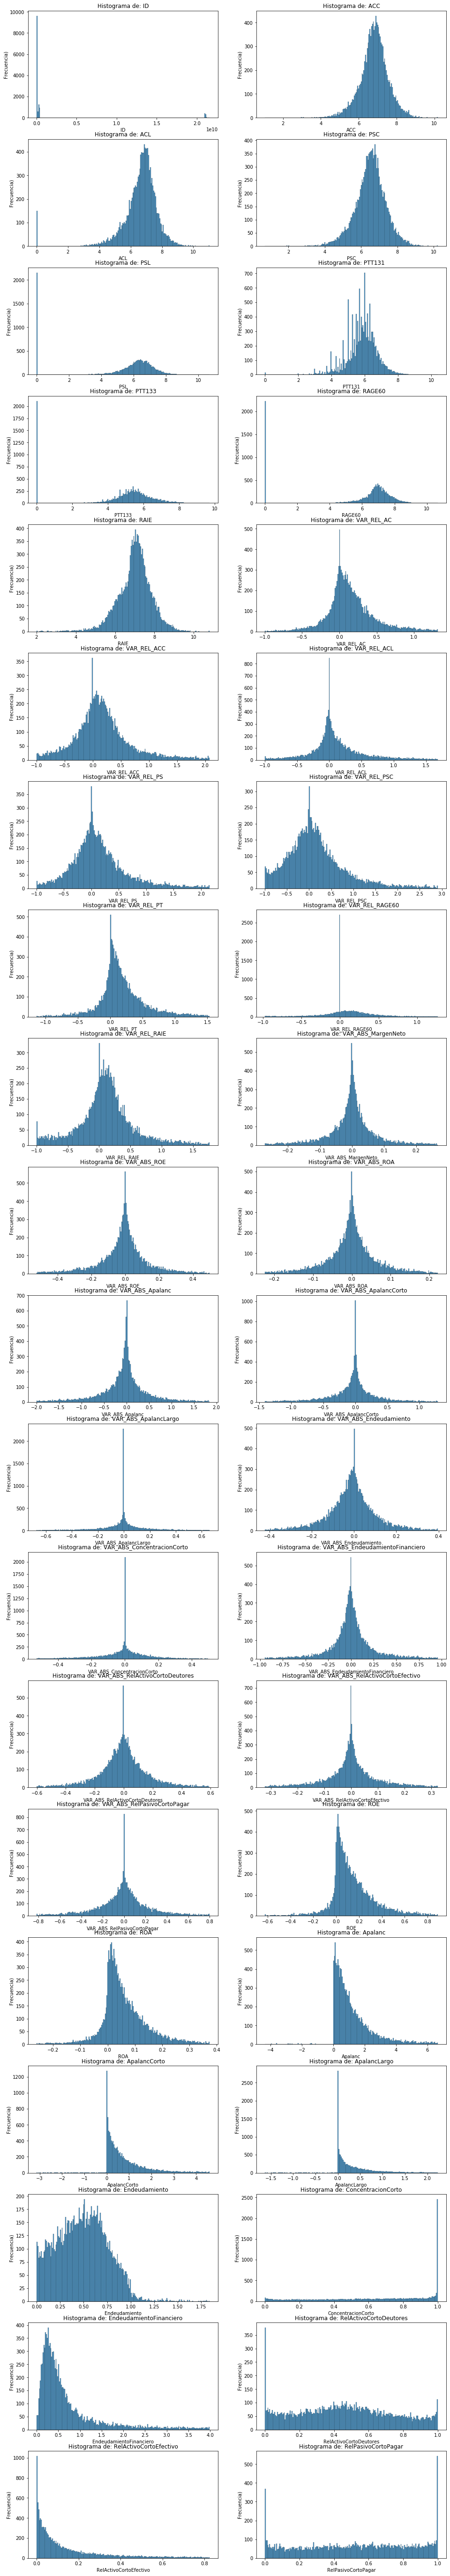

In [36]:
columnasNumericas = selectedVarsIndividual + variablesFinancierasBasicasVariacionesRelativas + variablesIndicadoresVariacionesAbsolutas + variablesIndicadoresContinuas
columnasCategoricas = variablesRelacionesDiscretas

plotVariablesAll(ejercicios_nooutliers, columnasNumericas)

Se propone:

* Discretizar PTT133 ya que cuenta con muchos valores a 0 sin informar.
* Discretizar las variaciones relativas de PTT237, RAGE60.
    * Crear una categoría para el 0.
    * Crear categorías negativas y positivas para cada unidad de cambio.
* Eliminar las variaciones absolutas de apalancamiento a largo y concentración corto, ya que tienen mayoría de valores a 0.
* Discretizar ConcentracionCorto utilizando la misma estrategia que con las proporciones del activo.

In [37]:
temp = ejercicios_nooutliers.drop(['VAR_ABS_ApalancLargo','VAR_ABS_ConcentracionCorto'], axis=1)

temp['PTT133_CAT'] = pd.cut(temp['PTT133'], bins=[-np.inf,0, 6, 6.5, 7, np.inf], labels=False, duplicates='drop')
temp['VAR_REL_RAGE60_CAT'] = pd.cut(temp['VAR_REL_RAGE60'], bins=[-np.inf,-0.5,-0.0001,0, 0.5, 1, np.inf], labels=False, duplicates='drop')
temp['ConcentracionCorto_CAT'] = pd.cut(temp['ConcentracionCorto'], bins=[-np.inf,0, 0.3, 0.7, np.inf], labels=False, duplicates='drop')

ejercicios_clean = temp.drop(['PTT133','VAR_REL_RAGE60','ConcentracionCorto'], axis=1)

Y se observan las distribuciones de las variables categóricas.

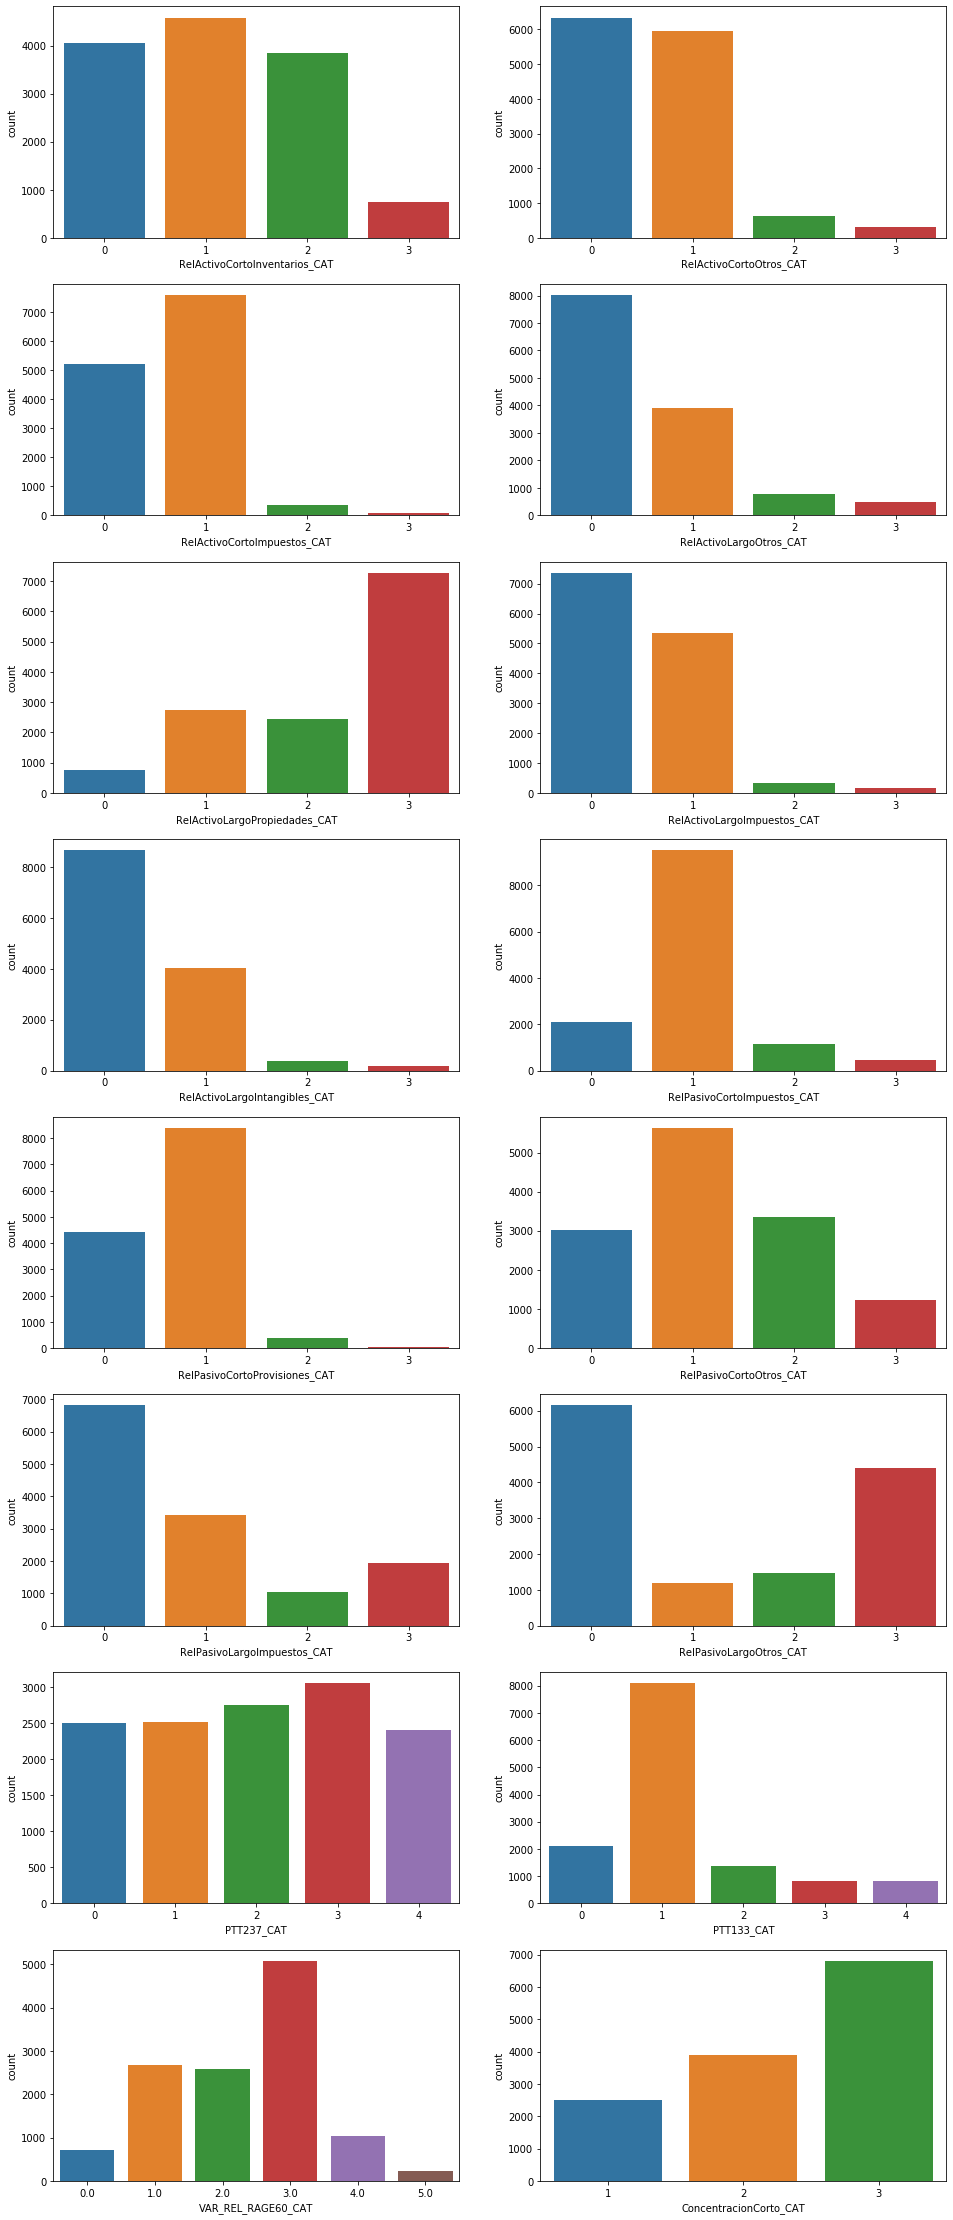

In [38]:
def plotCategorical(df, variables):
    numCols = 2
    numRows = math.ceil(len(variables) / 2)
    figSize = numRows * 5
    # Construir las visualizaciones con los histogramas de las principales variables fiscales
    fig, axes = plt.subplots(numRows,numCols, figsize=(16,figSize))
    for i, v in enumerate(variables):
        row = int(i / numCols)
        col = i % numCols
        sns.countplot(data=df,x=v,ax=axes[row][col])
        
    if (len(variables) < numCols * numRows):
        axes[numRows-1,numCols-1].axis('off')
        
    plt.show()


categoricalCols = [v for v in ejercicios_clean.columns.tolist() if v.endswith("_CAT")]
plotCategorical(ejercicios_clean, categoricalCols)

Se miran las correlaciones entre todas las variables finales creadas. Respecto a las numéricas:

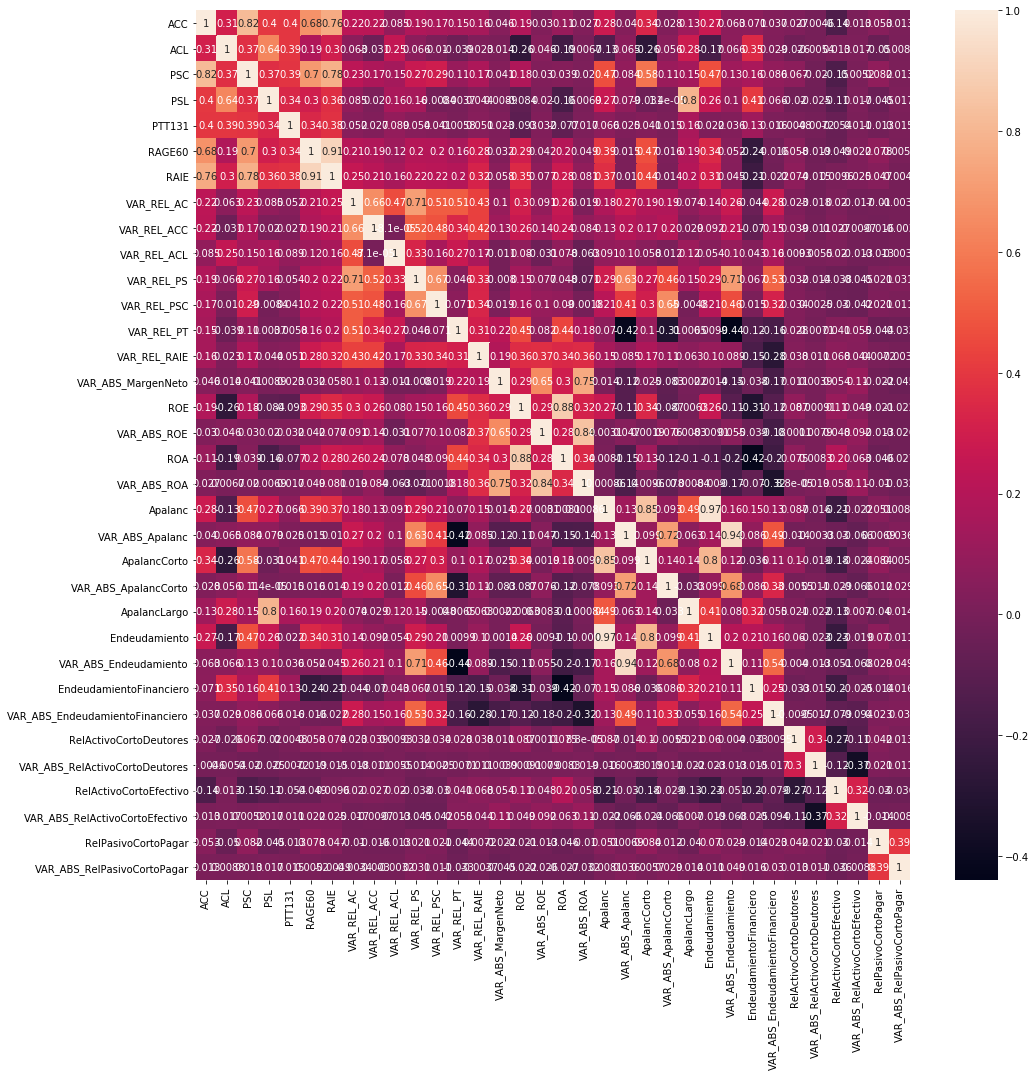

In [39]:
numericalCols = [v for v in ejercicios_clean if v not in categoricalCols + ['ID']]
corr_plot(ejercicios_clean, numericalCols)

Existen correlaciones fuertes entre:

* Endeudamiento y apalancamiento. Se puede deducir a partir de las fórmulas que el endeudamiento es igual al apalancamiento + 1, por lo que se presciende del apalancamiento.
* VAR_ABS_Endeudamiento y VAR_ABS_Autonomía: lo mismo que antes. Se presciende de VAR_ABS_Autonomia.
* RAIE y RAGE60: Se presciende de RAGE60.

Se eliminan estas variables y se guarda el dataset a un fichero csv.

In [40]:
ejercicios_final = ejercicios_clean.drop(['Apalanc','VAR_ABS_Apalanc','RAGE60'], axis=1)
ejercicios_final.to_csv('data/EjerciciosAgregados.csv', index=False, sep=";")